# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Volatility Forecast using GARCH models 

Volatility describes uncertainties surrounding the potential price movements of financial assets and is one of the most active research in Time Series Analysis. Volatility is not directly observable and is estimated through asset price's return fluctuations. After completing the notebook, you will be able to make sophisticated volatility forecast using GARCH and evaluate model performance. 

In this notebook, you will perform the following steps:

1. [Get the Stock data](#data)
2. [Calculate Daily Return](#return)
3. [Search Optimal Parameters](#grid_search)
4. [Forecast using GARCH model](#forecast)
5. [Model Performance](#performance)

## Step 1: Get Stock Data<a id='data'></a>

We'll continue our work with VISA stock prices.

In [1]:
# Import Pandas Datareader
import pandas_datareader as pdr

# Set the start and end date
start_date = '01-Jan-10'
end_date = '01-Feb-20'

# Set the ticker
ticker = 'V'  # VISA

# Using Yahoo Finance API
data = pdr.get_data_yahoo(ticker, start_date, end_date)

# Print the top 5 rows of the pandas DataFrame
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,22.045000,21.792500,21.995001,21.865000,12643600.0,20.213949
2010-01-04,22.192499,21.865000,22.000000,22.035000,20180000.0,20.371117
2010-01-05,21.882500,21.500000,21.825001,21.782499,25833600.0,20.137684
2010-01-06,21.770000,21.475000,21.752501,21.490000,16254000.0,19.867273
2010-01-07,21.750000,21.387501,21.492500,21.690001,27841200.0,20.052168


## Step 2: Compute Daily Price Return and Annualized Volatility<a id='return'></a>

In [2]:
# compute daily return in percentage
data['Daily Return'] = data['Adj Close'].pct_change()*100

# compute sample standard deviation of returns
data['std_dev'] = data['Daily Return'].rolling(14).std()

# annualized volatilty
data['volatility'] = data['std_dev'] * ((252)**0.5)

# drop Nan rows
data.dropna(inplace=True)

# Print the top 5 rows of the pandas dataFrame
data.head()

,High,Low,Open,Close,Volume,Adj Close,Daily Return,std_dev,volatility
Date,,,,,,,,,
2010-01-22,21.097500,20.410000,21.007500,20.682501,29776400.0,19.120741,-2.036734,1.412325,22.419957
2010-01-25,20.952499,20.352501,20.850000,20.507500,16147200.0,18.958960,-0.846104,1.375525,21.835786
2010-01-26,20.635000,20.247499,20.337500,20.287500,12437600.0,18.755571,-1.072782,1.373033,21.796222
2010-01-27,21.032499,20.152500,20.219999,20.977501,19335200.0,19.393465,3.401089,1.695863,26.920991
2010-01-28,21.120001,20.352501,21.090000,20.662500,13070800.0,19.102253,-1.501599,1.700236,26.990416


One may use a different window for calculating sample standard deviation. It is advised to stick to 14 though! The reason being, the 'arch' package uses a similar window size of 14 days to calculate variance. You'll see the results while evaluating model performance. 

With that been said, have a look at <a href="https://www.kevinsheppard.com/">personal website</a> of the developer of this very helpful 'arch' python package. He is an Associate Professor at Oxford University who specializes in research related to volatility and uncertainty. 

In [3]:
# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('seaborn-darkgrid')

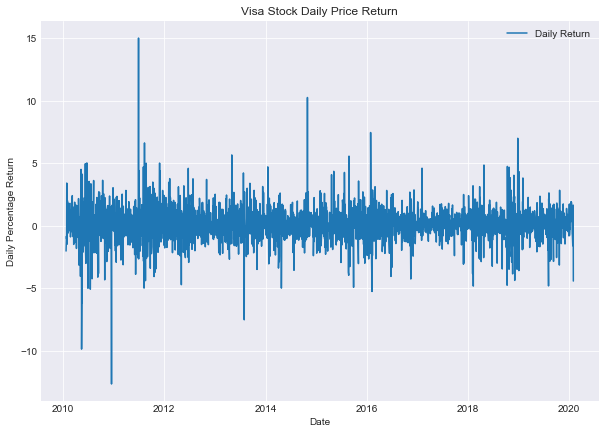

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10, 7)

# Plot the Daily Price Return of Visa stock price
plt.plot(data['Daily Return'])
plt.title('Visa Stock Daily Price Return')
plt.xlabel('Date')
plt.ylabel('Daily Percentage Return')
plt.legend(['Daily Return'])
plt.show()

The above plot looks like a stationary time series and thus we can use this data to model volatility. Recall one can check stationarity using ADF test.

### Augmented Dickey Fuller(ADF) Test

In [7]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Probability value of observing the result in our data by chance
p_value = adfuller(data['Daily Return'])[1]

if p_value > 0.05:
    print(
        "The p-value is: {p_value} > 0.05, hence time series is not stationary.".format(p_value=p_value))
else:
    print(
        "Time series is stationary. The p-value is: {p_value} < 0.05".format(p_value=p_value))

Time series is stationary. The p-value is: 0.0 < 0.05


ADF test confirms that Daily Return Time Series is indeed stationary.

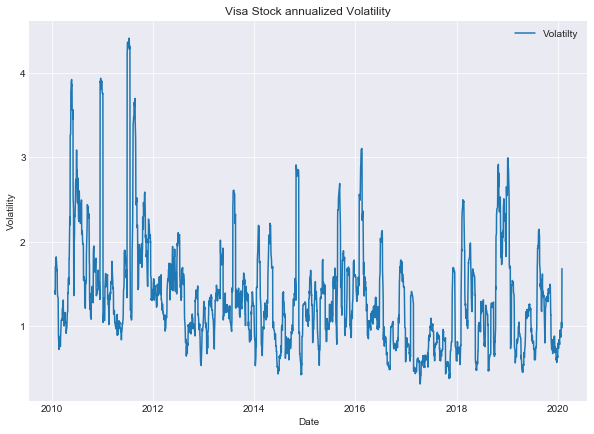

In [8]:
# Plot the Annualized Volatilty of Visa stock price
plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(data['std_dev'])
plt.title('Visa Stock annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(['Volatilty'])
plt.show()

In the above plot Note that periods of high volatility are followed by periods of low volatility. This is termed as Volatility Clustering and is commonly observed in financial asset price time series. There's a practical explanation of this behaviour. The market tends to respond to new information shocks with dramatic price movements quickly. With time the effects of shocks die, and market returns to its low volatile period. 

## Step 3: Search optimal parameters for GARCH model<a id='grid_search'></a>

The time-dependent systematic increase and decrease in volatility make modelling a challenging task. GARCH takes this into account by introducing various model hyperparameters that can be tuned to make realistic volatility forecast. This includes making distribution assumptions for residuals and mean return assumptions apart from the p,q values.

We'll grid search p,q and distribution hyperparameters while tuning GARCH model and use Akaike Information Criterion(AIC) score as the performance metric. In practice the impact of mean return model assumptions is negligible, and we'll continue with the default value. 

### Performing train/test split
Before tuning hyperparameters, we'll split data into train and test set.

In [9]:
# Split data into train and test set
split = int(len(data)*0.90)
train_set, test_set = data[:split], data[split:]

### Performing Grid Search to select optimal hyperparameters

<font color='red'>Note: The below cell will take a little bit of time to run.</font>

In [10]:
# Import arch_model
from arch import arch_model

# Empty list to aic score
aic = []

# p,q values
p = range(1, 6)  # [1,2,3,4,5]
q = range(1, 6)  # [1,2,3,4,5]

# distribution values
dist = ['Normal', 't', 'skewt']

# empty list to store p,q,dist
p_q_dist = []

# aic score for different values of p,q,dist
for i in p:
    for j in q:
        for k in dist:
            # define GARCH model
            gm = arch_model(train_set['Daily Return'],
                            vol='Garch', p=i, q=j, dist=k)
            gm_fit = gm.fit(disp='off')  # fit the model
            aic_temp = gm_fit.aic  # get aic score
            keys_temp = (i, j, k)  # p,q,dist value
            p_q_dist.append(keys_temp)  # append p,q,dist
            aic.append(aic_temp)  # append aic score

In [12]:
# Store values in dictionary
import pandas as pd
aic_dict = {'p_q_dist': p_q_dist, 'aic': aic}

# Import Pandas

# Create DataFrame from dictionary
df = pd.DataFrame(aic_dict)

# Return minimum AIC value with the p,q values and optimal distribution choice
df[df['aic'] == df['aic'].min()]

,p_q_dist,aic
2,"(1, 1, skewt)",7710.615549


We got lowest AIC score for p=1, q=1 and Skewed Student's t-distribution. The distribution choice is in line with what is commonly observed in Financial World.

In [13]:
# Import arch_model
from arch import arch_model

# Define GARCH model
gm = arch_model(train_set['Daily Return'], vol='Garch', p=1, q=1, dist='skewt')

# Fit the model
gm_fit = gm.fit(disp='off')

### Standardized Residuals

We'll make use of Standardized Residuals to check the model performance. It is defined as Error Residual divided by the Conditional volatility value estimated by the model. If the GARCH model is good at modelling volatility, then the standardized residuals should resemble white noise, and the density plot should resemble a Normal Distribution.

In [14]:
# Obtain model estimated residuals and volatility
gm_resid = gm_fit.resid
gm_std = gm_fit.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid/gm_std

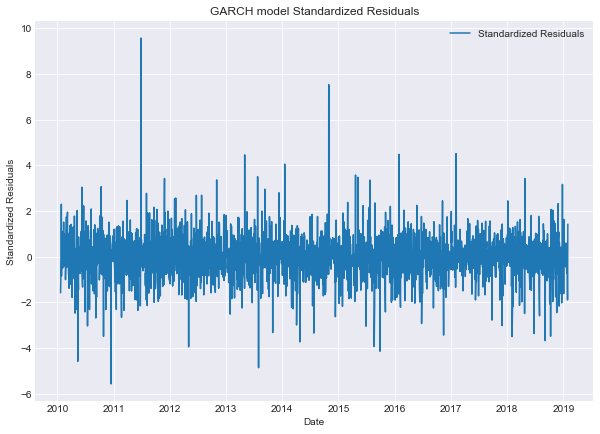

In [15]:
# Plot the Standardized Residuals
plt.plot(gm_std_resid)
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('GARCH model Standardized Residuals')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend(['Standardized Residuals'])
plt.show()

This looks like white noise as we cannot observe data clustering. Thus our model can be used to make volatility forecasts.

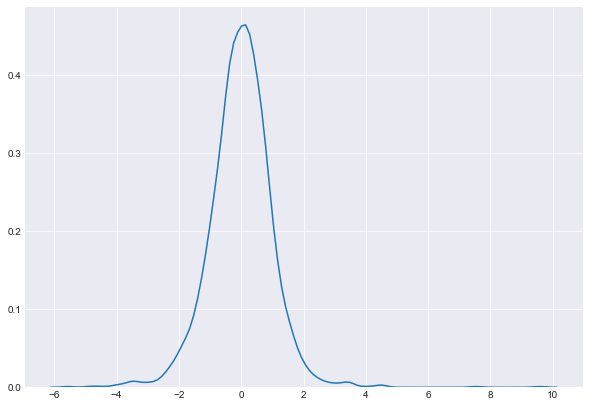

In [16]:
# Import Seaborn
import seaborn as sns

# Density plot
plt.rcParams["figure.figsize"] = (10, 7)
sns.distplot(gm_std_resid, hist=False, kde=True)
plt.show()

Above plot looks like Normal Distribution. Thus we should proceed to use this tuned model to make volatility forecast.

## Step 4: Forecast using tuned GARCH model<a id='forecast'></a>

We'll forecast using a rolling window approach similar to what followed in ARIMA notebook.

<font color='red'>Note: The below cell will take a little bit of time to run.</font>

In [17]:
# Convert pandas series to list for rolling window forecast
past = train_set['Daily Return'].tolist()

# Empty list for storing volatility predictions
predictions = []

# Perform rolling window forecast
for i in range(len(test_set)):
    gm = arch_model(past, vol='Garch', p=1, q=1, dist='skewt')  # define model
    gm_fit = gm.fit(disp='off')  # fit the model
    temp_forecast = gm_fit.forecast(horizon=1).variance  # make forecast
    # store forecast volatility
    temp_prediction = temp_forecast.iloc[-1].values[0]

    predictions.append((temp_prediction**0.5) * (252**0.5)
                       )  # append annualized prediction
    # add test value to train set
    past.append(test_set['Daily Return'].iloc[i])

In [18]:
# Predicted and actual Values
for i in range(0, 10):
    print('predicted={pred}, actual={test}'.format(
        pred=predictions[i], test=test_set['volatility'].iloc[i]))

predicted=22.34760672585771, actual=16.447721929051102
predicted=24.439158578729284, actual=23.523930603321446
predicted=33.31369398479989, actual=23.46542776035454
predicted=30.49682089358176, actual=23.5546717107705
predicted=27.882832145861837, actual=23.920653412354874
predicted=25.950172626590085, actual=24.405652648618858
predicted=24.67198984077817, actual=24.178154243829965
predicted=22.598534178784437, actual=24.10690871661842
predicted=20.85046658410442, actual=23.896759391011557
predicted=19.939278541932374, actual=24.11749145490018


## Step 5: Evaluate Model Performance<a id='performance'></a>

We'll calculate Error Residuals and MSE to check forecast performance.

### Residuals

In [19]:
# Create empty list
residual = []

# Append residuals
for i in range(len(test_set)):
    residual.append(predictions[i]-test_set['volatility'].iloc[i])

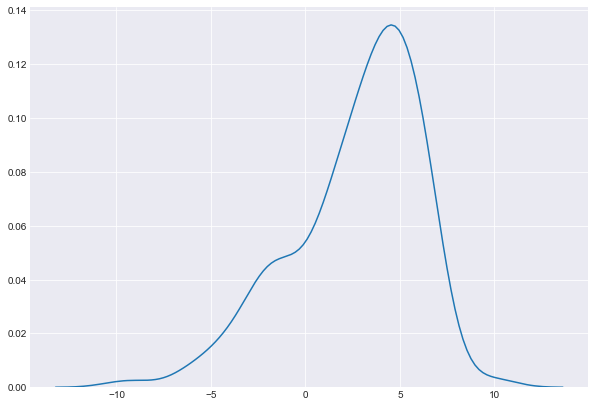

In [20]:
# Density plot
plt.rcParams["figure.figsize"] = (10, 7)
sns.distplot(residual, hist=False, kde=True)
plt.show()

Density Plot suggests that the model is good at making predictions, but there are some discrepancies. This is discussed at the end of the notebook.

### Mean Squared Error

In [21]:
# Import MSE
from sklearn.metrics import mean_squared_error

# Calculate MSE
error_mse = mean_squared_error(test_set['volatility'], predictions)
print('Test MSE: {mse}'.format(mse=error_mse))

Test MSE: 18.46475608963512


### Plotting predictions and test data 

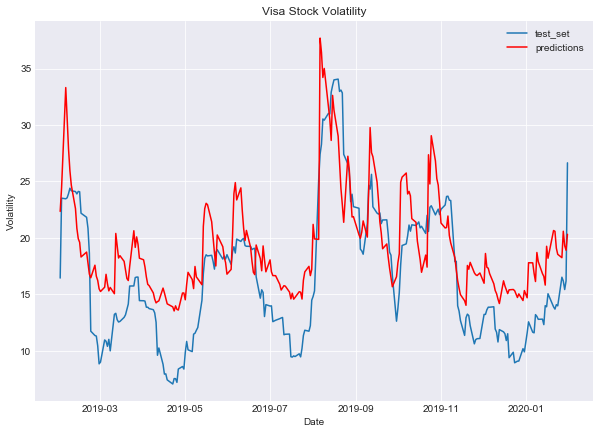

In [22]:
# Plot forecasted and actual values
plt.figure(figsize=(10, 7))
plt.plot(test_set['volatility'])
plt.plot(test_set.index, predictions, color='red')
plt.title('Visa Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(['test_set', 'predictions'])
plt.show()

As observed through the above plot, GARCH model predictions are more than volatility calculated using a rolling window approach.

Note that GARCH uses Exponential Weighted Moving Average (EWMA) to make variance calculations that give more weight to recent price data. The difference is, predictions from GARCH model are noisier but statistically correct. 

The GARCH model indeed did a great job at making volatility forecasts. Now that you know how to use GARCH model. You can experiment with it and work on your understanding of the model.

1. Use different data sets: Try out the model on different data sets and compare model performance!
2. Asymmetric Shocks: In the real financial world, asset price tends to grow slowly and take a sharp dip. We can improve volatility estimates by taking this factor into account while modelling. This is implemented in the 'arch' package using EGARCH and GJR-GARCH volatility models. Experiment with them and see if there is any significant increase in model performance.
3. Rolling Window Forecast: We performed an expanding rolling window forecast, where new data points are added iteratively. There's another approach where one can drop initial points while adding new data points. This is termed as Fixed Rolling Window Forecast since the training window size is kept fixed. Try and compare the model performance.

In the next unit, you will learn about Options Trading Greeks.
<br><br>